<font size=+3><center><b>Predicting Customer Churn with Machine Learning 🏦💰</b></center></font>

<br>

**Table of Contents**

- [Introduction](#Introduction)
- [Objective](#Objective)
- [Libraries](#Libraries)
- [A Quick Look at our Data](#A-Quick-Look-at-our-Data)
- [Creating a Test Set](#Creating-a-Test-Set)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Target Variable: Exited](#Target-Variable:-Exited)
    - [Continuous Variables](#Continuous-Variables)
    - [Categorical Variables](#Categorical-Variables)
- [Data Preprocessing](#Data-Preprocessing)
    - [Feature Selection](#Feature-Selection)
    - [Addressing Class Imbalance](#Addressing-Class-Imbalance)
- [Building Machine Learning Models](#Building-Machine-Learning-Models)
    - [Baseline Models](#Baseline-Models)
    - [Model Tuning](#Model-Tuning)
- [Results](#Results)
    - [Feature Importance](#Feature-Importance)
- [Evaluating the Test Set](#Evaluating-the-Test-Set)
- [Conclusions](#Conclusions)
  

<br>

# Introduction


Customer churn (also known as customer attrition) occurs when a customer stops using a company's products or services. 

Customer churn affects profitability, especially in industries where revenues are heavily dependent on subscriptions (e.g. banks, telephone and internet service providers, pay-TV companies, insurance firms, etc.). It is estimated that acquiring a new customer can cost up to five times more than retaining an existing one.

![Customer Churn](data/src/customer-churn.png)

<br>

# Objective

The goal of this notebook is to understand and predict customer churn for a bank. Specifically, we will initially perform **Exploratory Data Analysis** (**EDA**) to identify and visualise the factors contributing to customer churn. This analysis will later help us build **Machine Learning** models to predict whether a customer will churn or not. 

This problem is a typical **classification** task. The task does not specify which performance metric to use for optimising our machine learning models. I decided to use **recall** since correctly classifying elements of the positive class (customers who will churn) is more critical for the bank.

<br>

# Import Libraries
Ignore these for now

In [31]:
!pip install numpy pandas scikit-learn matplotlib scipy scikit-plot imblearn Jinja2
!pip install seaborn --upgrade

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
# pd.set_option('precision', 3)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


import seaborn as sns
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

import warnings
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
warnings.filterwarnings("ignore", message="The palette list has more values.*")
warnings.filterwarnings("ignore", message="set_ticklabels.*")

print('✔️ Libraries Imported!')

font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

print('✔️ Default Parameters and Variables Set!')

✔️ Libraries Imported!
✔️ Default Parameters and Variables Set!


<br>

# Graphing Functions

These graphing functions will help us display our data. You can safely ignore the details.

In [33]:
def plot_continuous(feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = train_df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();

def plot_categorical(feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=train_df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=train_df,
                palette=colors_cat,
                ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout();

def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);

def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);

def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout();


def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');


def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);


print('✔️ Graphing Functions Defined!')

✔️ Graphing Functions Defined!


<br>

# A Quick Look at our Data

We start by importing the dataset as a Pandas DataFrame. We can also take a look at the top five rows using the `head()` method:

In [34]:
df = pd.read_csv('data/Churn_Modelling.csv')

print('✔️ Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

✔️ Dataset Imported Successfully!

It contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our DataFrame has 14 features/attributes and 10K customers/instances. The last feature, '**Exited**', is the **target variable** and indicates whether the customer has churned (0 = No, 1 = Yes). The meaning of the rest of the features can be easily inferred from their name.

Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped:

The `info()` method can give us valuable information such as the number of non-null values and the type of each feature:

In [35]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Thankfully, there are **no missing values** in our DataFrame. The `describe()` method gives us a statistical summary of the numerical features:

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


- Customers ages ranges from 18 to 92, with a mean value approximately equal to 39,
- The mean (and median) tenure is 5 years, so the majority of customers is loyal,
- Approximately 50% of customers are active.

<br>

# Creating a Test Set

We create a test split to evaluate a model's performance on unseen data and assess its ability to generalize. By using a separate test set, we can avoid overfitting to the training data and ensure the model's performance is reliable in real-world scenarios.

![Overfitting vs Underfitting](data/src/over-under-fit.png)

![Test vs Training Error](data/src/test-train-error.webp)


In [37]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print('Train set: {} rows x {} columns'.format(train_df.shape[0],
                                               train_df.shape[1]))
print(' Test set: {} rows x {} columns'.format(test_df.shape[0],
                                               test_df.shape[1]))

Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


<br>

# Exploratory Data Analysis

## Target Variable: Exited

The target variable is what we are trying to predict classification on. Our target variable will be `Exited`.

- Zero (0) for a customer that has **not** churned, and
- One (1) for a customer that has churned.

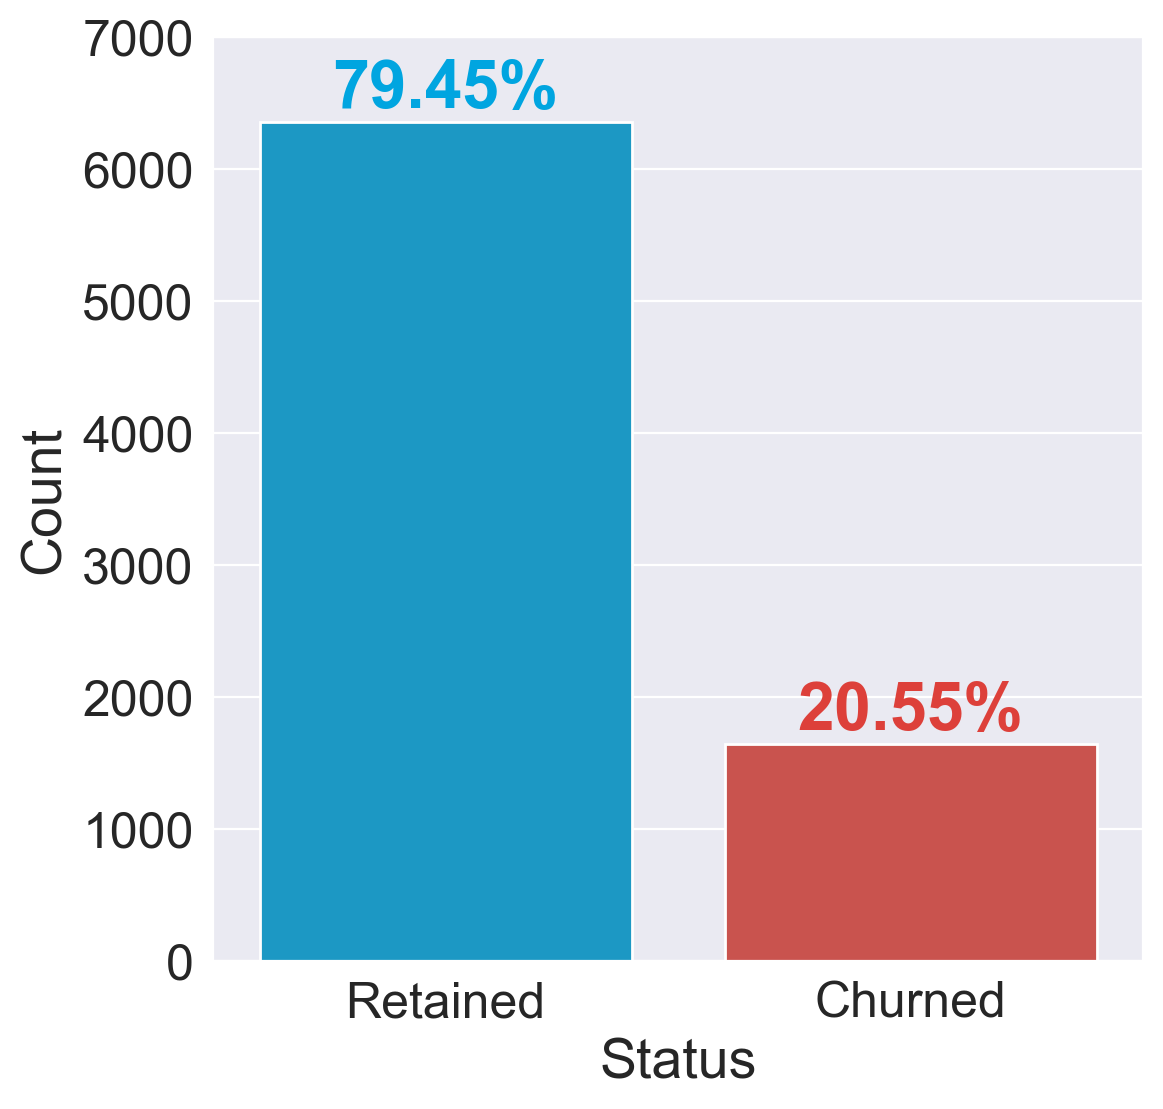

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 2))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size + 4)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 7000]);

The bank kept 80% of its clientele.

Notice that our dataset is **skewed/imbalanced** since the number of instances in the 'Retained' class outnumbers the number of instances in the 'Churned' class by a lot. Therefore, accuracy is probably not the best metric for model performance.

In [39]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


## Continuous Variables

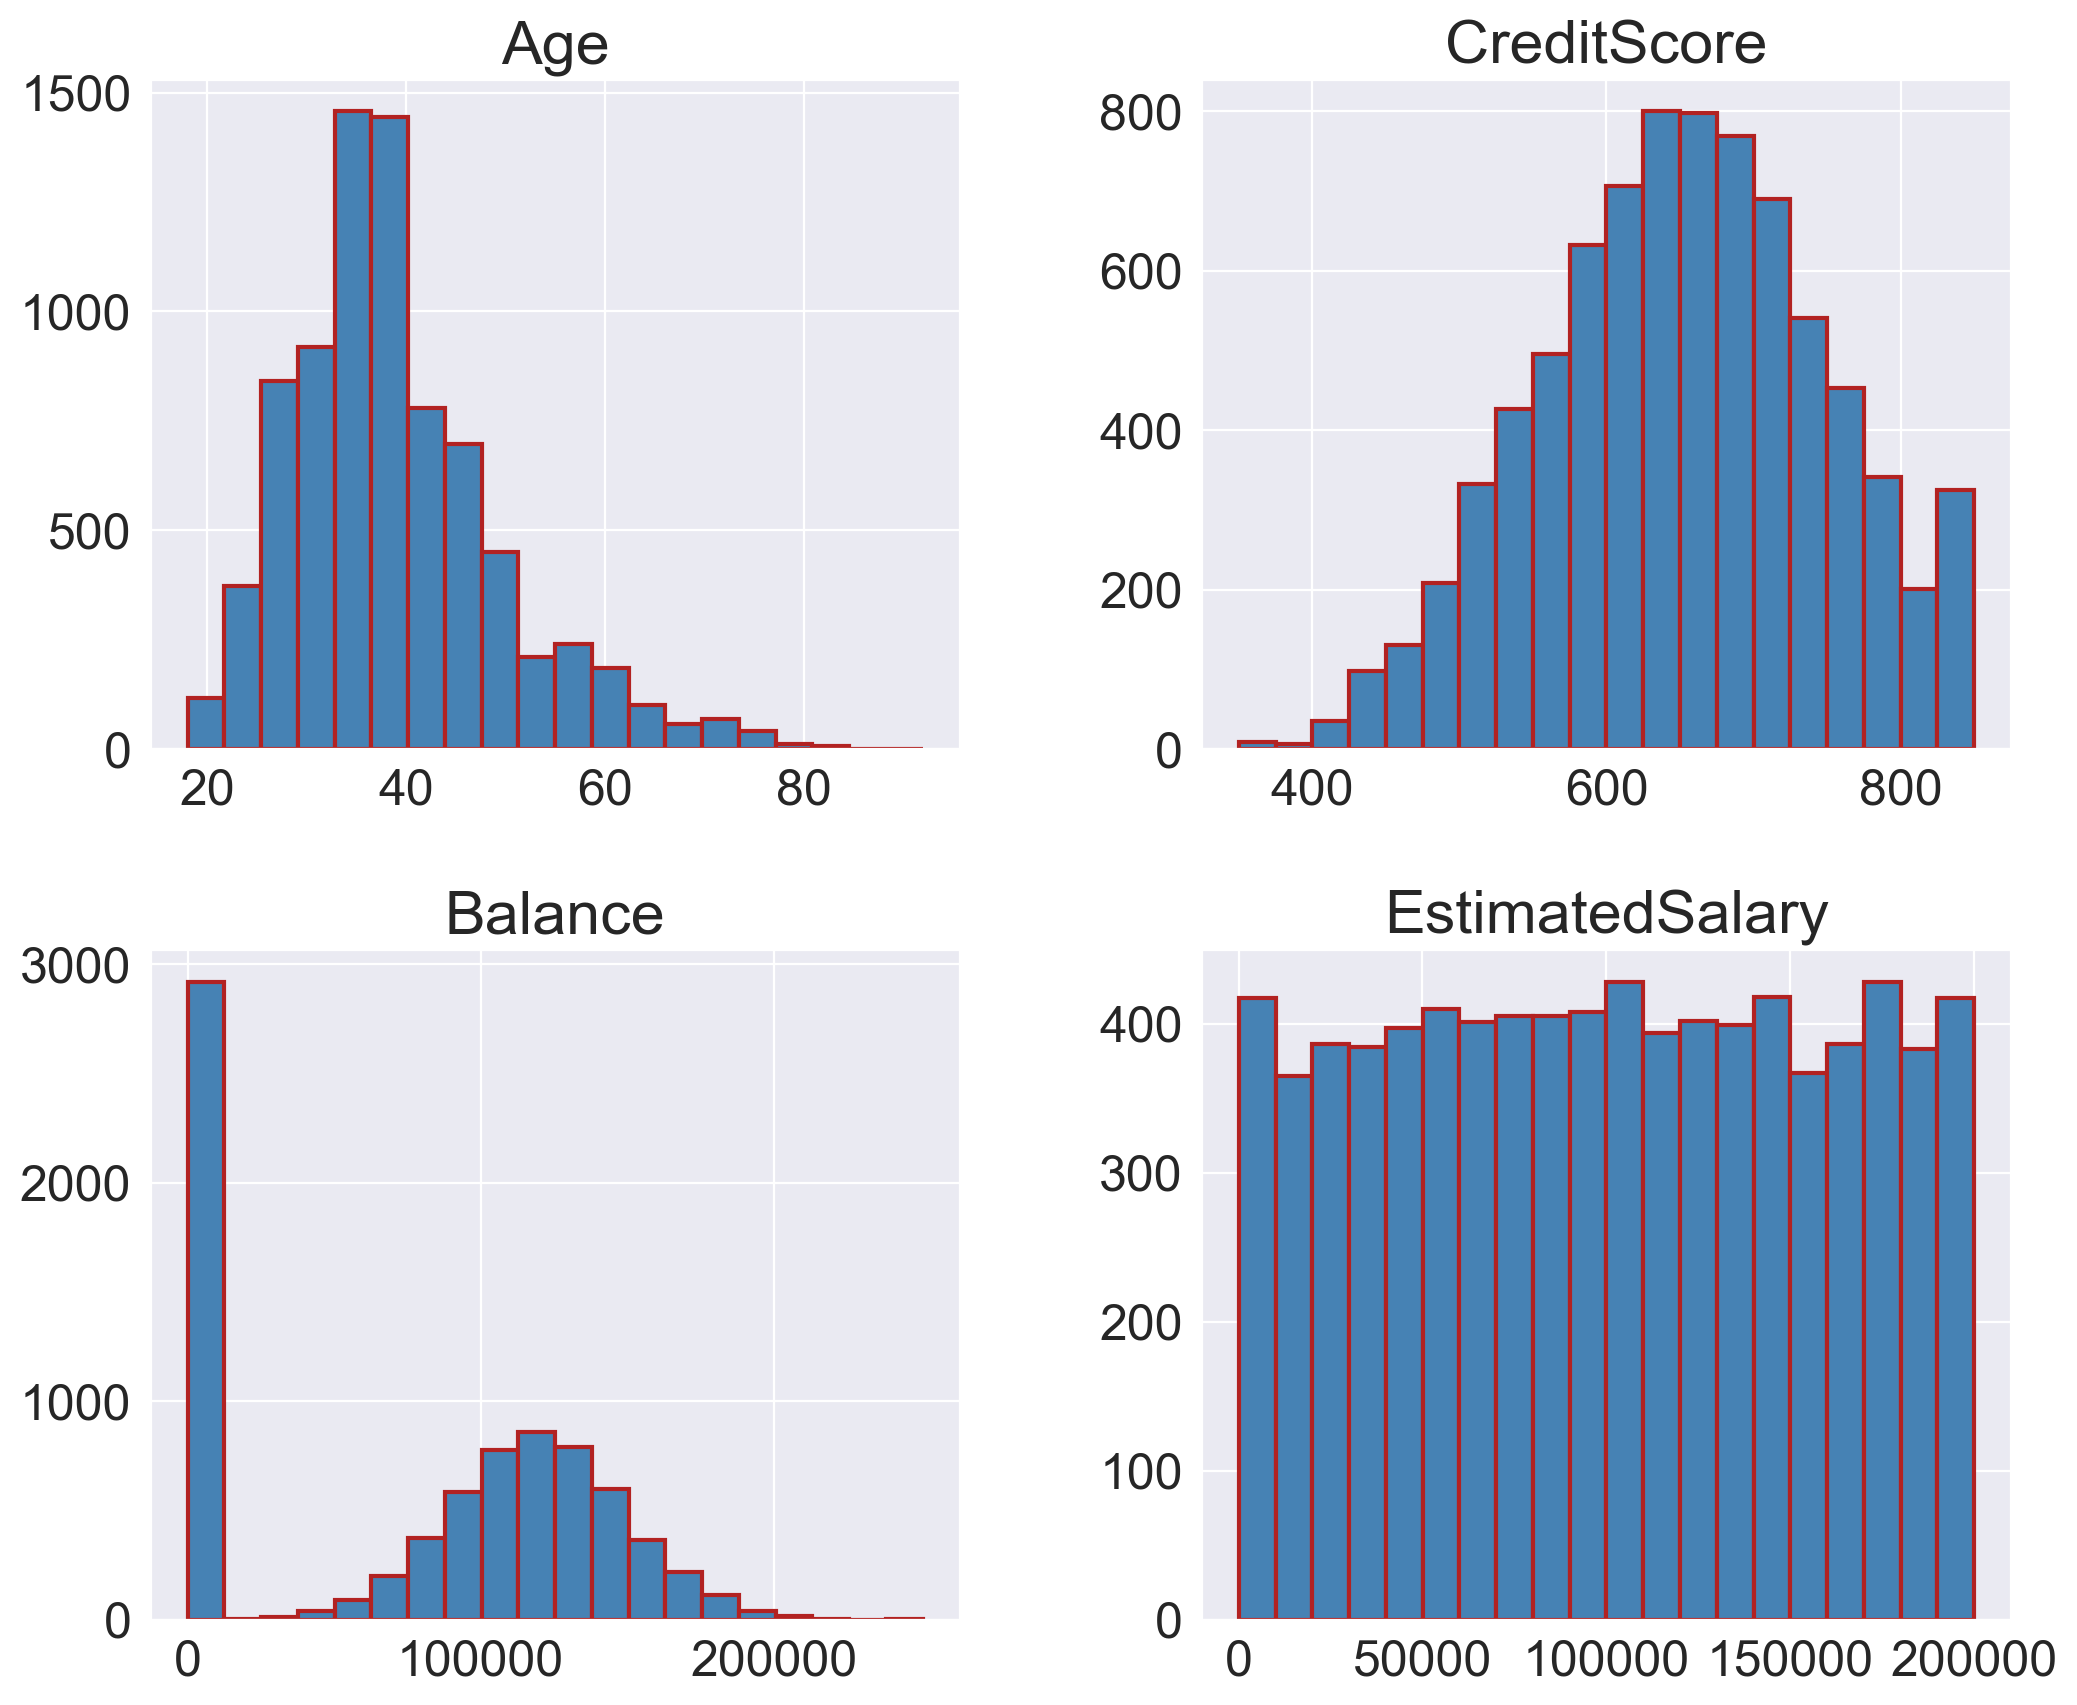

In [40]:
train_df[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);

- 'Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left,
- Most values for 'CreditScore' are above 600,
- If we ignore the first bin, 'Balance' follows a fairly normal distribution, and
- The distribution of 'EstimatedSalary' is more or less uniform and provides little information.

## Looking for Correlations

We can compute the standard correlation coefficient between every pair of (continuous) features using the pandas' `corr()` method and plot it as a matrix:

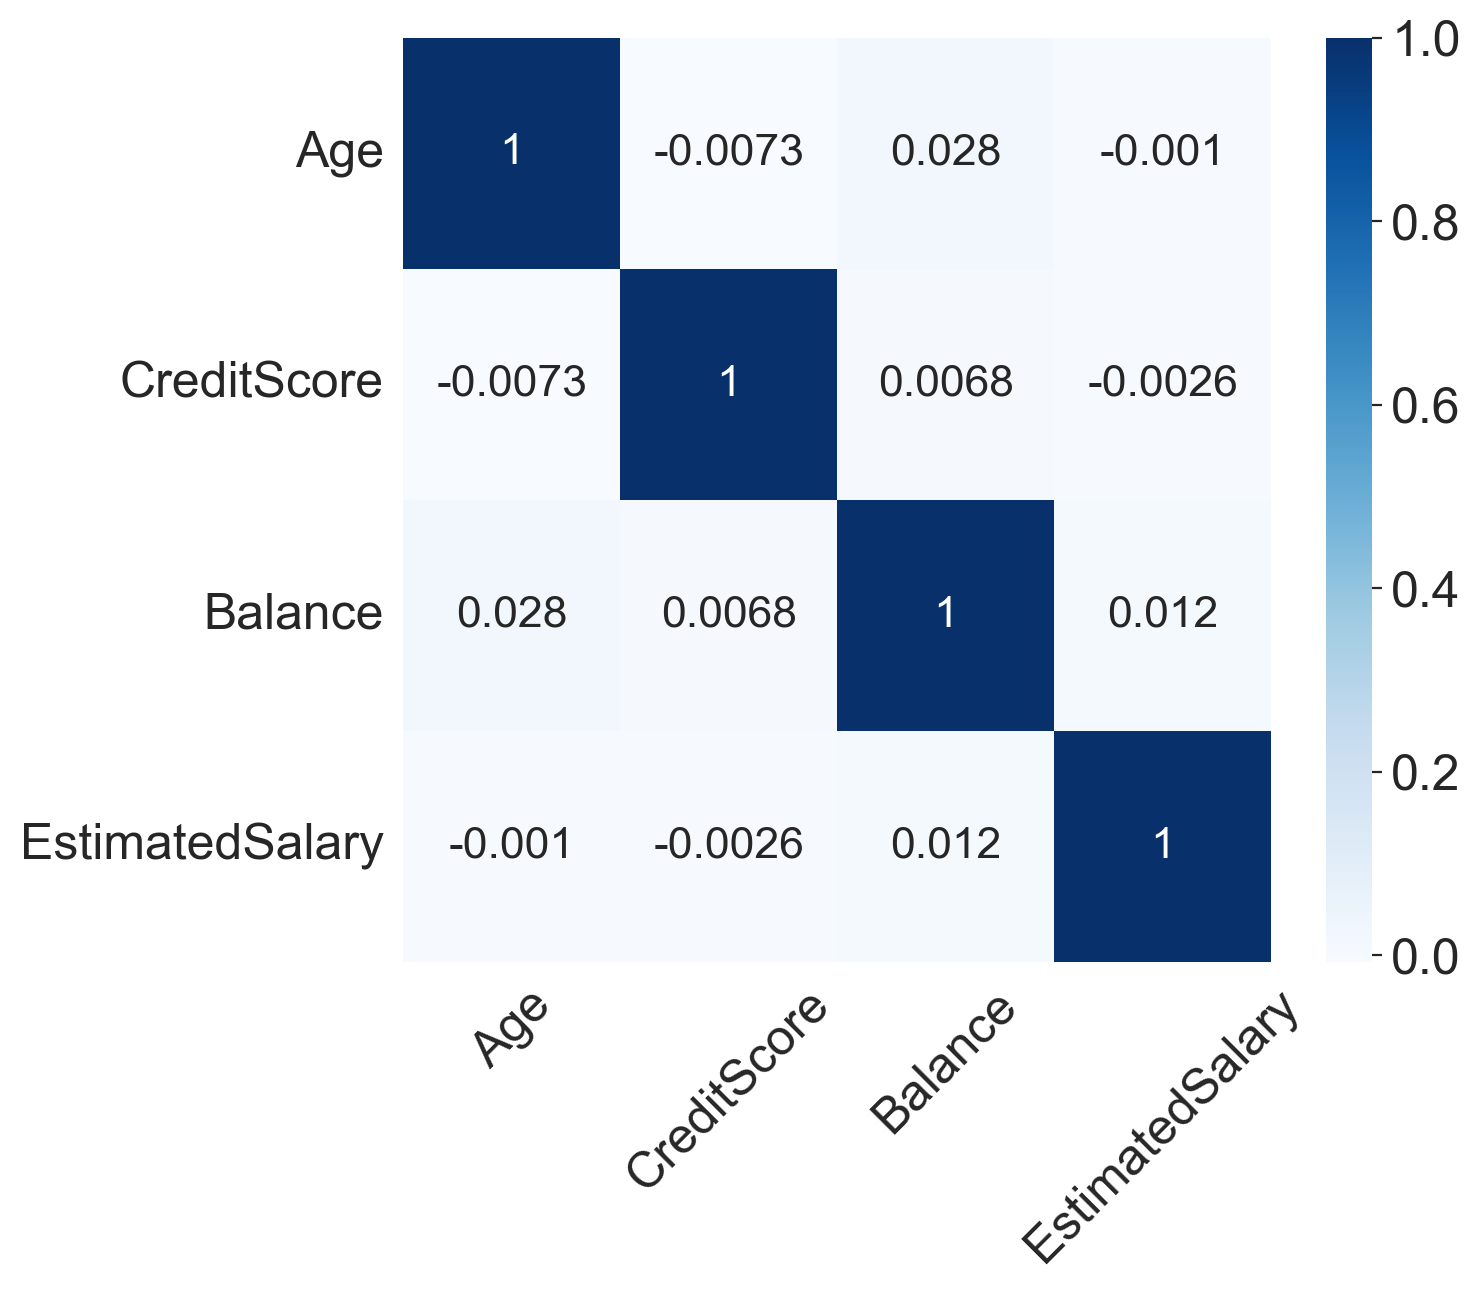

In [41]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

There is no significant intercorrelation between our features, so we do **not** have to worry about multicollinearity.

Let's look at these features in greater detail.

### Age

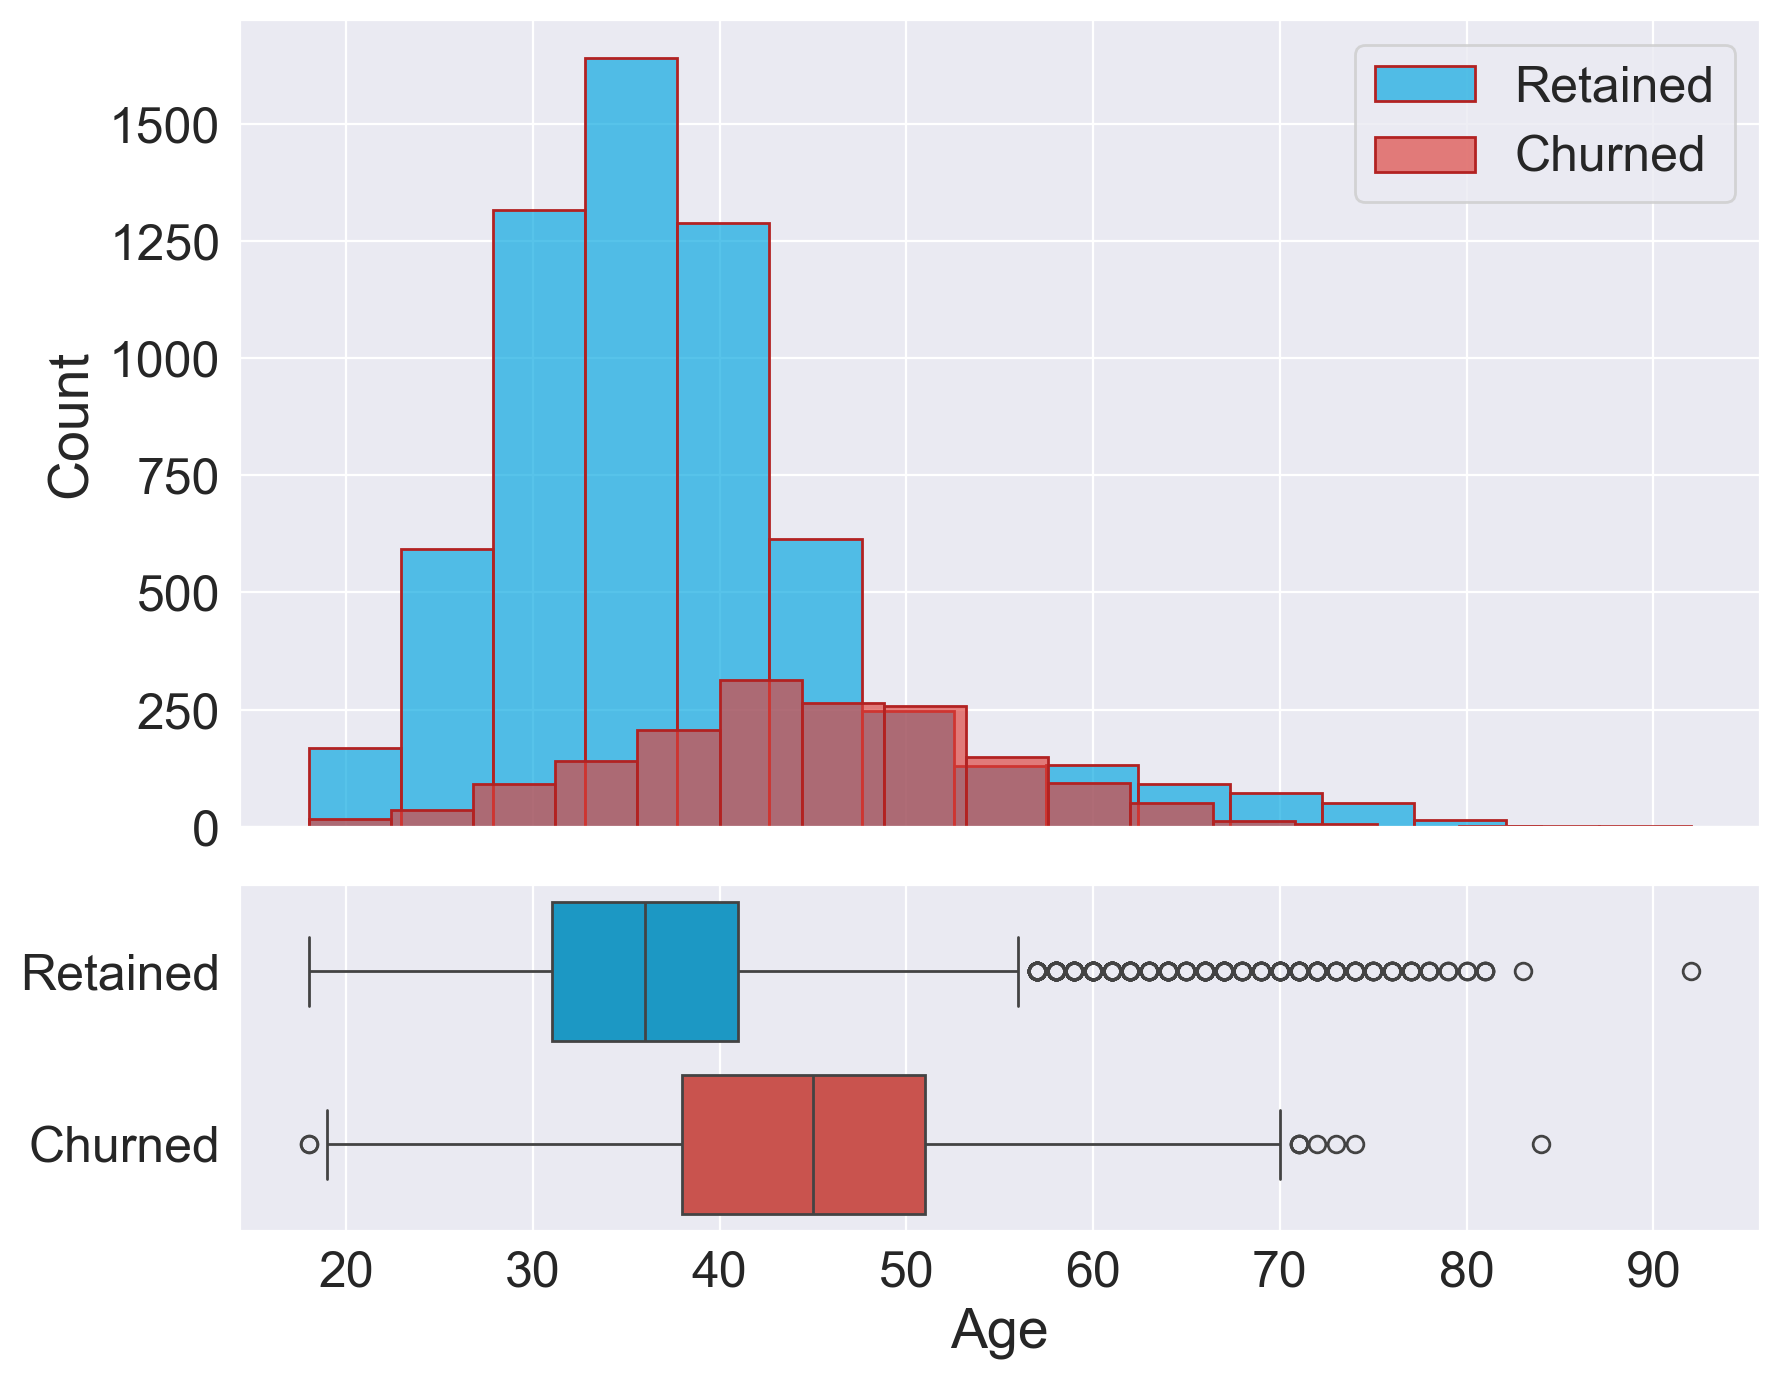

In [42]:
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

Interestingly, there is a clear difference between age groups since older customers are more likely to churn. This observation could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers.

## Categorical Variables

Let's plot a seaborn.countplot for each categorical feature:

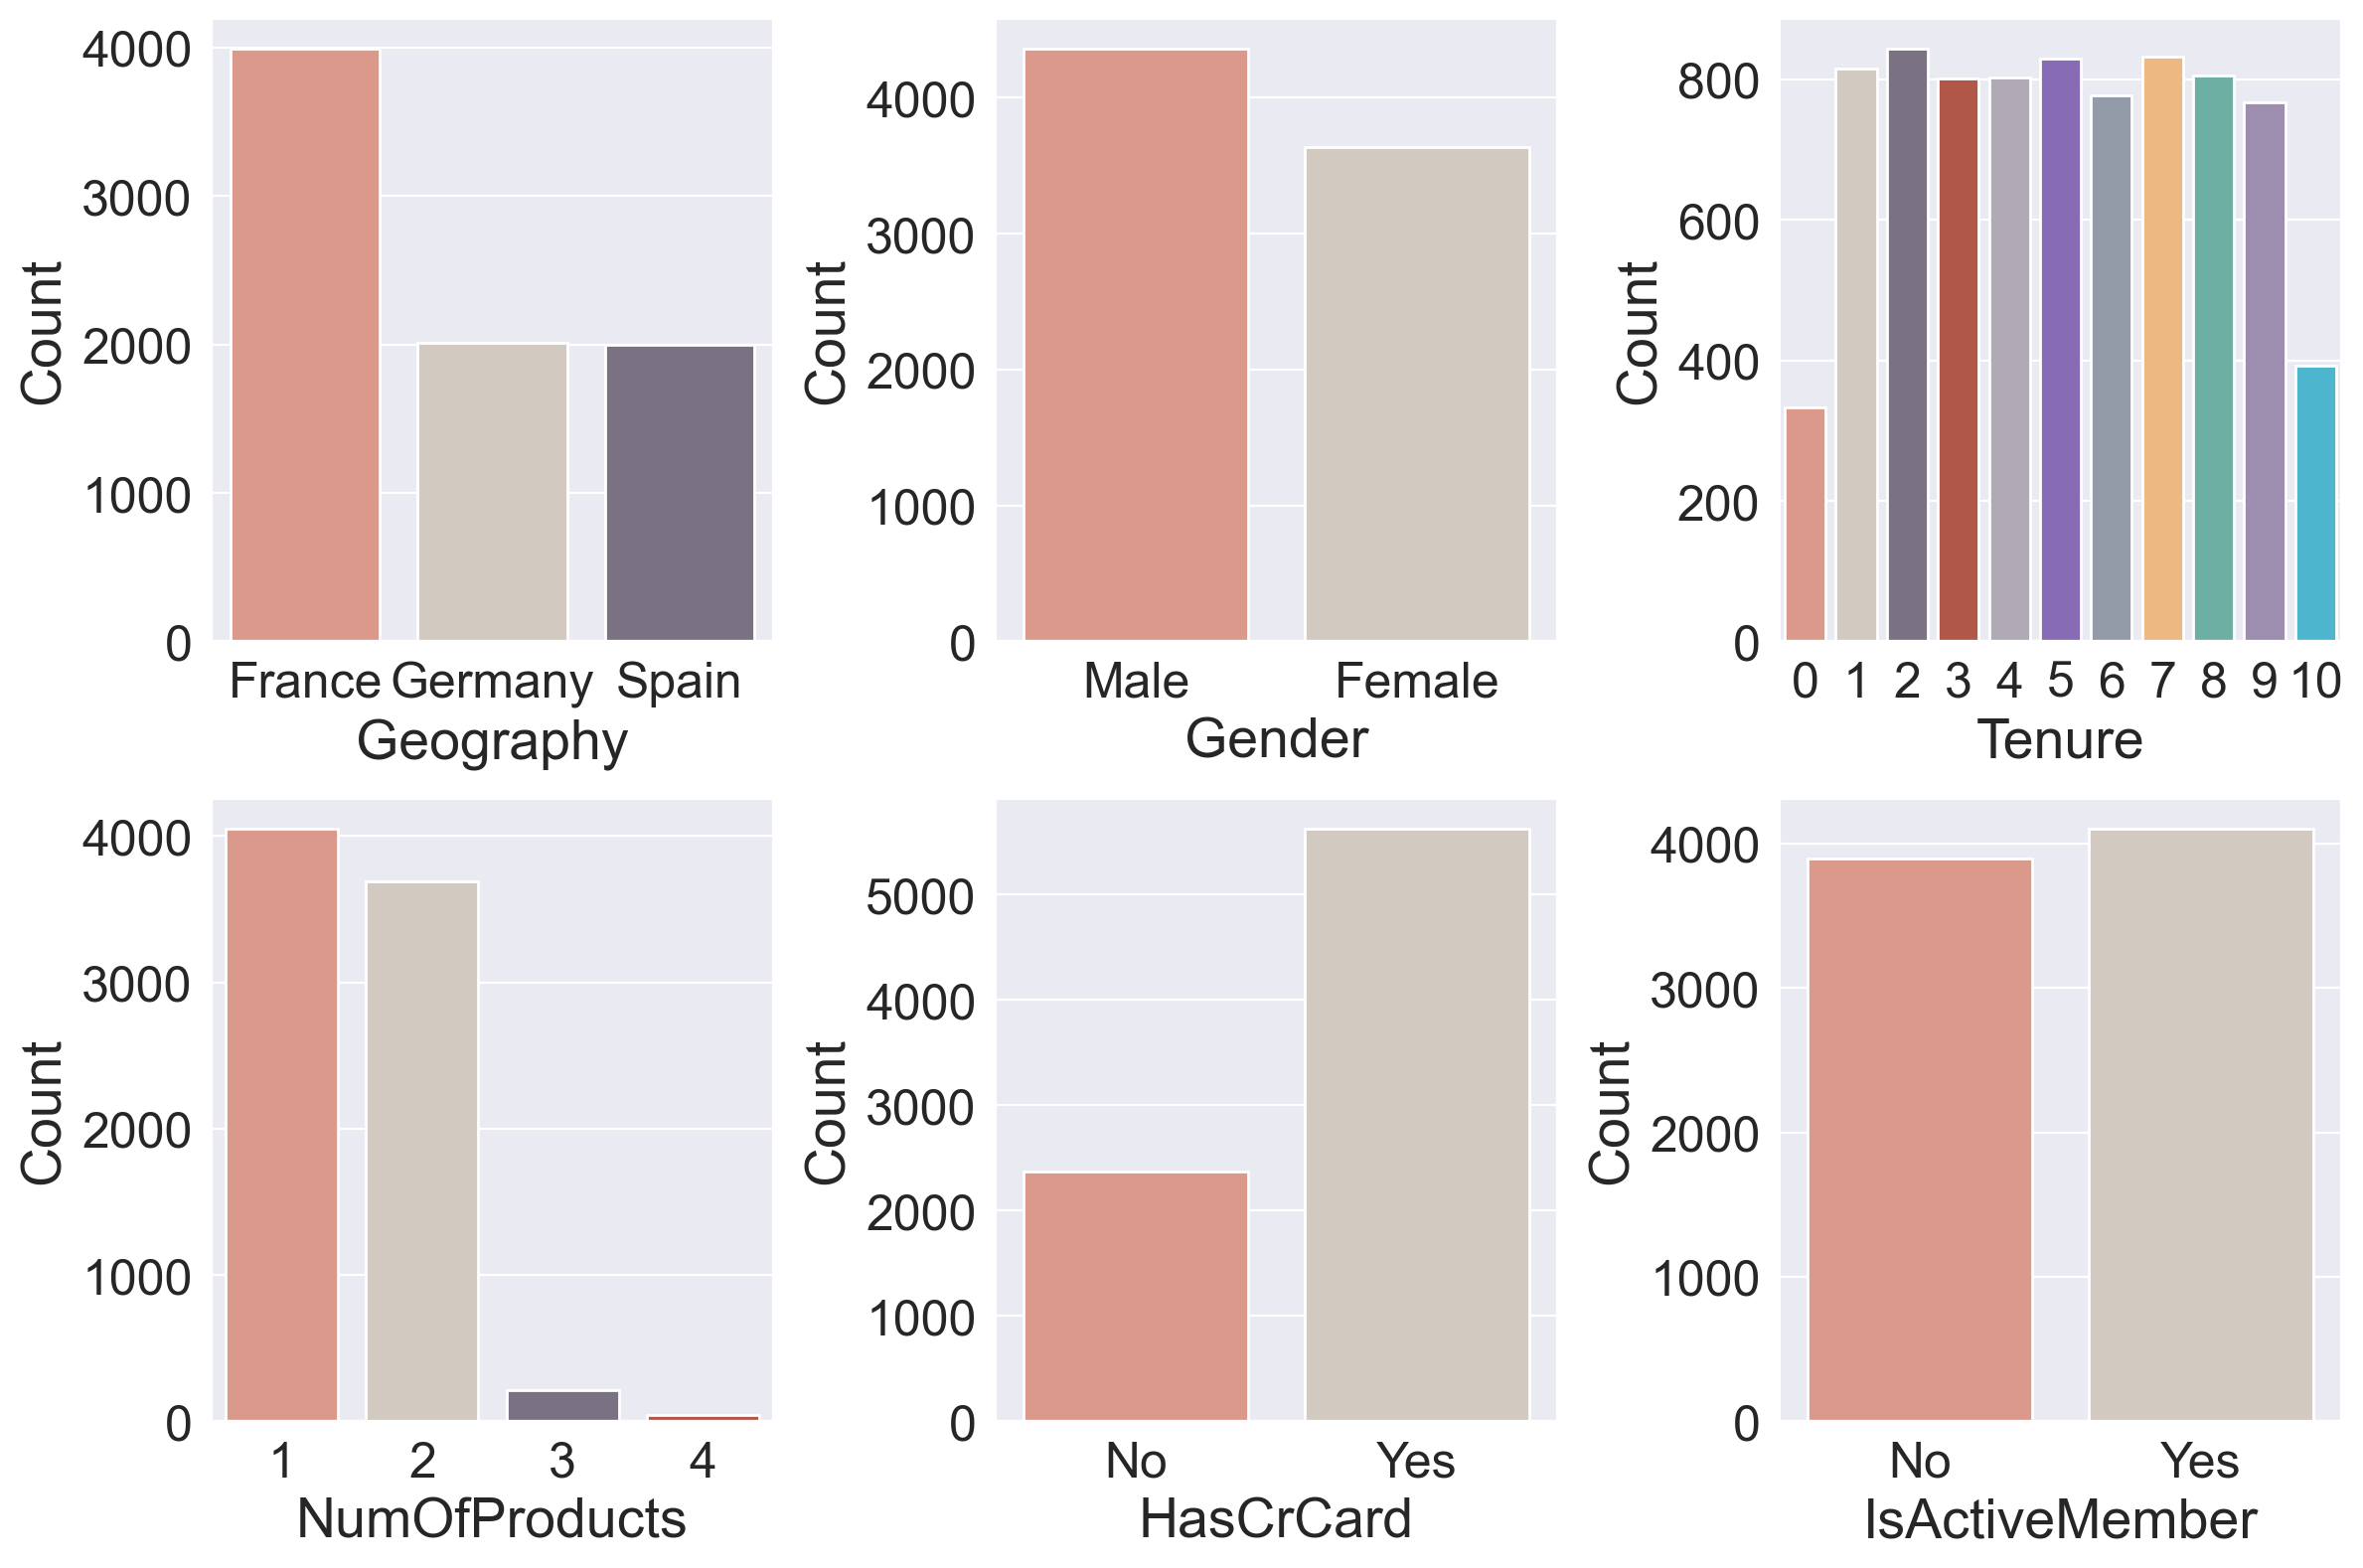

In [43]:
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

Important points:

- The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
- There are more male customers than females,
- Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
- Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
- A significant majority of customers has a credit card, and
- Almost 50% of customers are not active.

Again, we will look at these features in greater detail.

### Gender

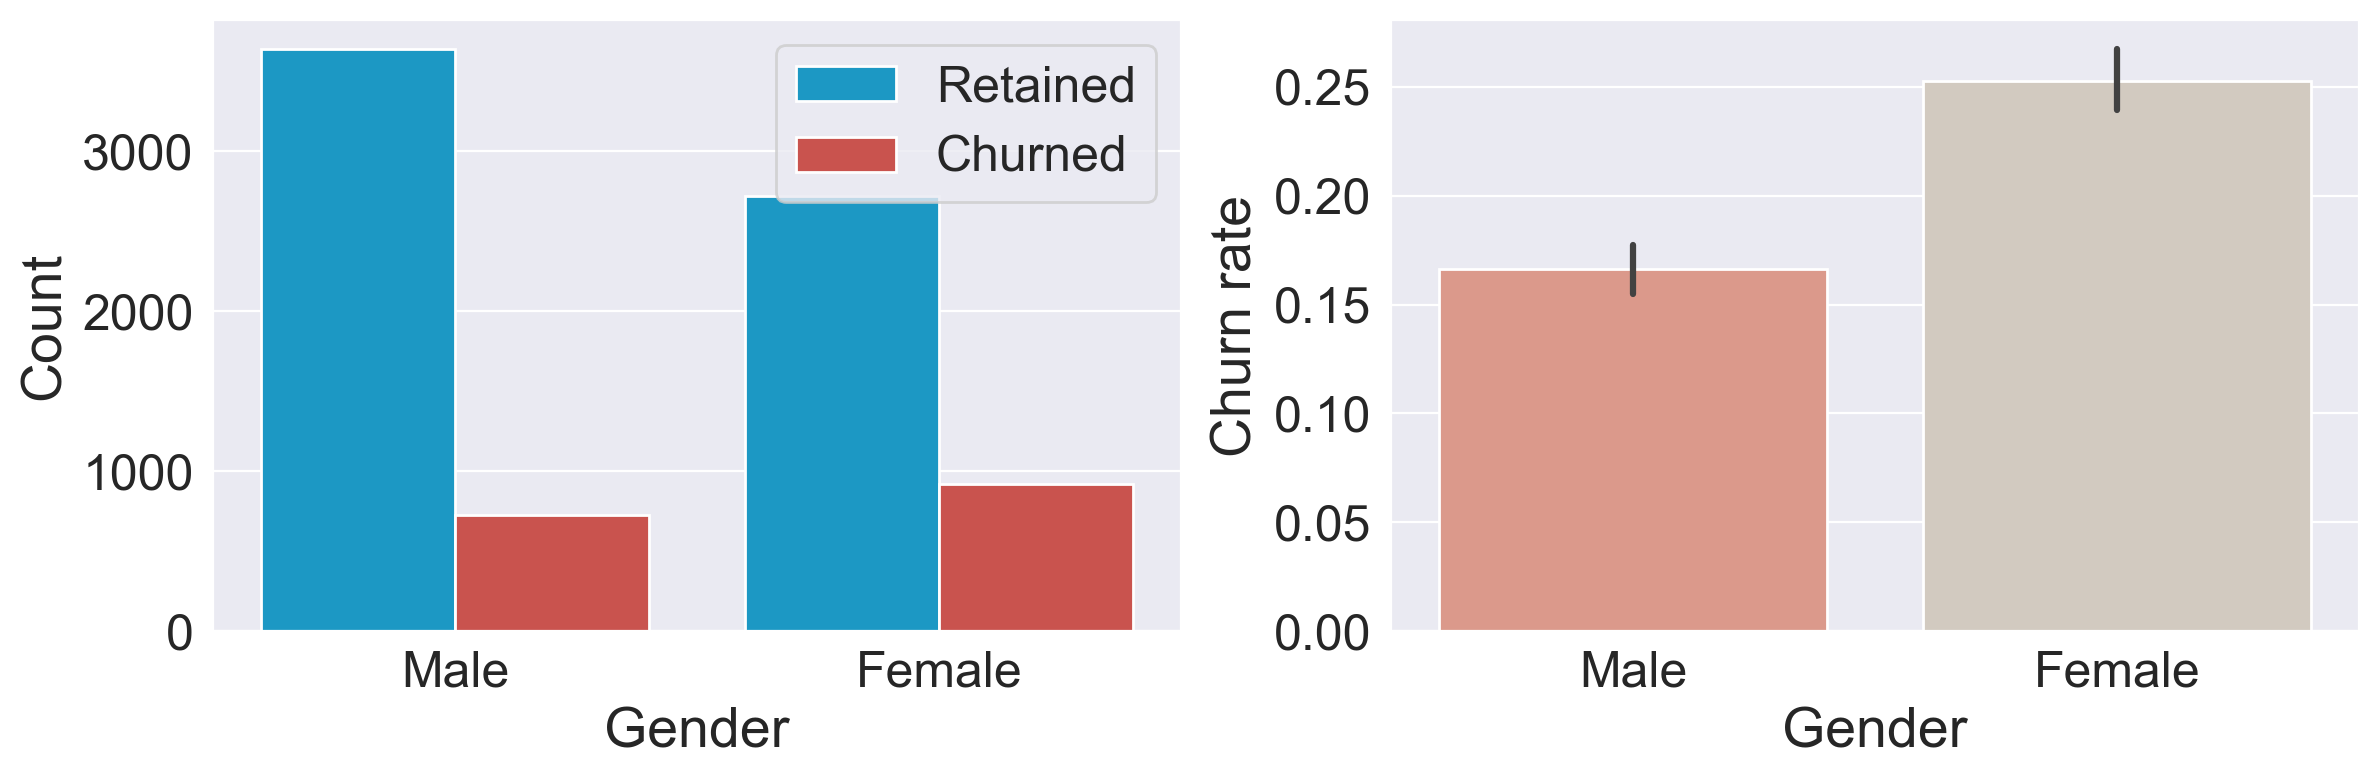

In [44]:
plot_categorical('Gender')

Female customers are more likely to churn.

### Number of Products

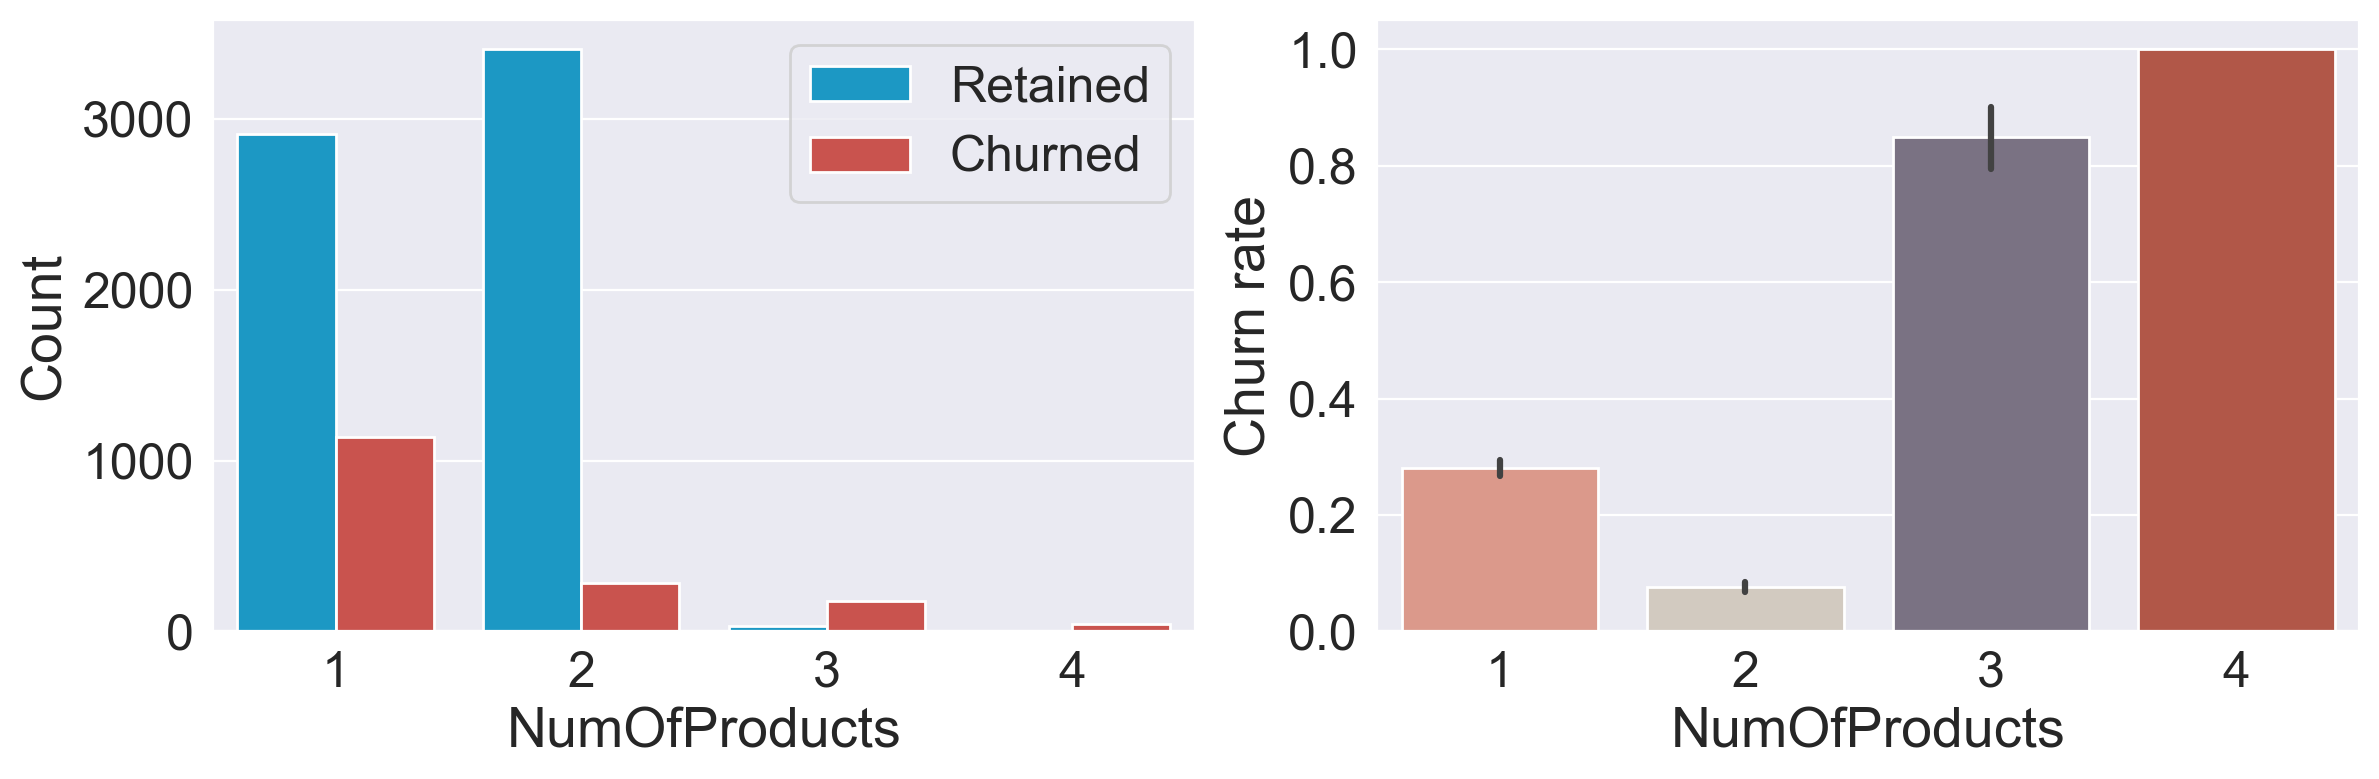

In [45]:
plot_categorical('NumOfProducts')

Interestingly, having 3 or 4 products significantly increases the likelihood of churn. It could potentially mean that the bank cannot properly support customers with more products which in turn increases customer dissatisfaction.

### Active Members

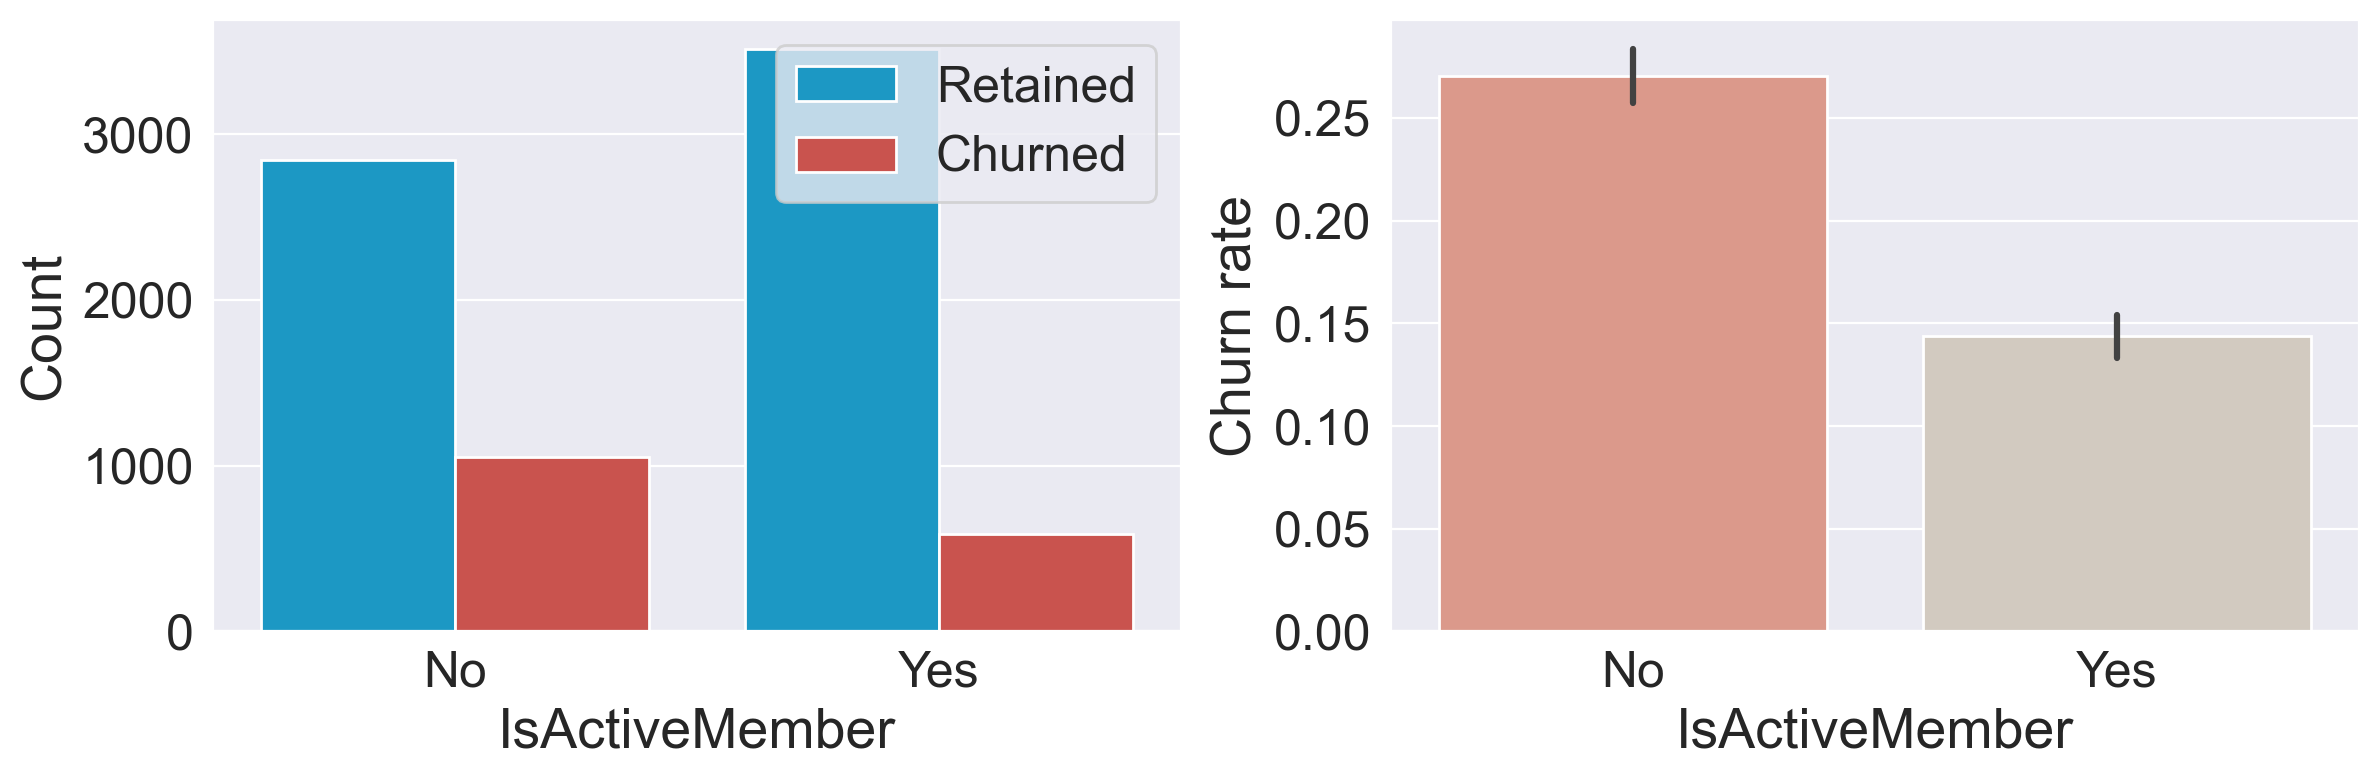

In [46]:
plot_categorical('IsActiveMember')

It's not a surprise that inactive customers are more likely to churn. A significant portion of the clientele is inactive; therefore, the bank will benefit from changing its policy so that more customers become active.

<br>

# Data Preprocessing

Data preprocessing is the process of converting raw data into a well-readable format that is suitable for building and training Machine Learning models.

This will be out of scope of today's workshop, but we can perform methods such as feature selection, label encoding and scaling.

In [47]:
chi2_array, p_array = [], []
for column in categorical:

    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

print('✔️ Features Dropped!')

train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

print('✔️ Features Encoded!')

scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print('✔️ Features Scaled!')

✔️ Features Dropped!
✔️ Features Encoded!
✔️ Features Scaled!


Finally, we will split the train set into 'X_train' and 'y_train' sets:

In [48]:
y_train = train_df['Exited']
X_train = train_df.drop(['Exited'], axis=1)
print('✔️ Sets Created!')

✔️ Sets Created!


## Addressing Class Imbalance

As we have seen previously, there is an imbalance in the classes to be predicted, with one class (0 – retained) much more prevalent than the other (1 - churned):

In [49]:
y_train.value_counts()

Exited
0    6356
1    1644
Name: count, dtype: int64

Class imbalance is usually a problem and occurs in many real-world tasks. Classification using imbalanced data is biased in favour of the majority class, meaning that machine learning algorithms will likely result in models that do little more than predict the most common class. 

Imagine the classification of a rare disease that only occurs in 0.01% of the population. If the model classifies everyone as not having the disease, it will be 99.99% accurate, which is very misleading.

This is out of scope for today's workshop, but there are techniques for resampling data that allow us to create artificial data for balancing.

In [50]:
over = SMOTE(sampling_strategy='auto', random_state=random_state)
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

Exited
0    6356
1    6356
Name: count, dtype: int64

# Model Evaluation

## Confusion Matrix

![Confusion Matrix](data/src/confusion-matrix.png)

### Confusion Matrix Metrics

__Precision__: When we predict a positive outcome, precision tells us the proportion of those predictions that are actually correct.

_Example_: In a spam email detection system, precision measures how many of the emails classified as spam are actually spam. High precision means that when the system labels an email as spam, it is highly likely to be spam.

__Recall__: Recall tells us the proportion of actual positive instances that our model correctly identifies.

_Example_: In a disease diagnosis system, recall measures how many of the actual disease cases are correctly identified by the model. High recall means that the model is able to identify a high percentage of the actual disease cases.

![Confusion Matrix Metrics](data/src/confusion-metrics.png)

<br>

# Building Machine Learning Models

## Baseline Models

We start this section by first creating two simple models to estimate the **baseline performance** on the training set. Specifically, we will use Gaussian Naïve Bayes. We will use their default parameters and evaluate their (mean) recall by performing **k-fold cross-validation**. The idea behind k-fold cross-validation, which is illustrated in [this figure](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png), is simple: it splits the (training) set into k subsets/folds, trains the models using k-1 folds, and evaluates the model on the remaining one fold. This process is repeated until every fold is tested once.

In [51]:
clf_list = [('Gaussian Naive Bayes', GaussianNB())]

cv_base_mean, cv_std = [], []
for clf in clf_list:

    cv = cross_val_score(estimator=clf[1],
                         X=X_train,
                         y=y_train,
                         scoring=scoring_metric,
                         cv=5,
                         n_jobs=-1)

    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

print('Baseline Models (Recall):')

for i in range(len(clf_list)):
    print('   {}: {}'.format(clf_list[i][0], np.round(cv_base_mean[i], 2)))

Baseline Models (Recall):
   Gaussian Naive Bayes: 0.7


## Model Tuning

We are now ready to start building machine learning models. The two classifiers I have selected are the following:

1) [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), <br>
3) [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), <br> 

Using default hyperparameters usually results in non-optimised models that overfit or underfit the dataset. **Hyperparameter tuning** is the process of finding the set of hyperparameter values that achieves optimal performance. For this purpose, we will first define which hyperparameters we want to experiment with and what values to try out. We will pass this information to Scikit-Learn’s `GridSearchCV`, which then evaluates all the possible combinations of hyperparameter values.

### Logistic Regression

![Logistic Regression](data/src/Logistic-Regression.png)


 Logistic Regression
-------------------------------
   Best Score (recall): 0.73
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear


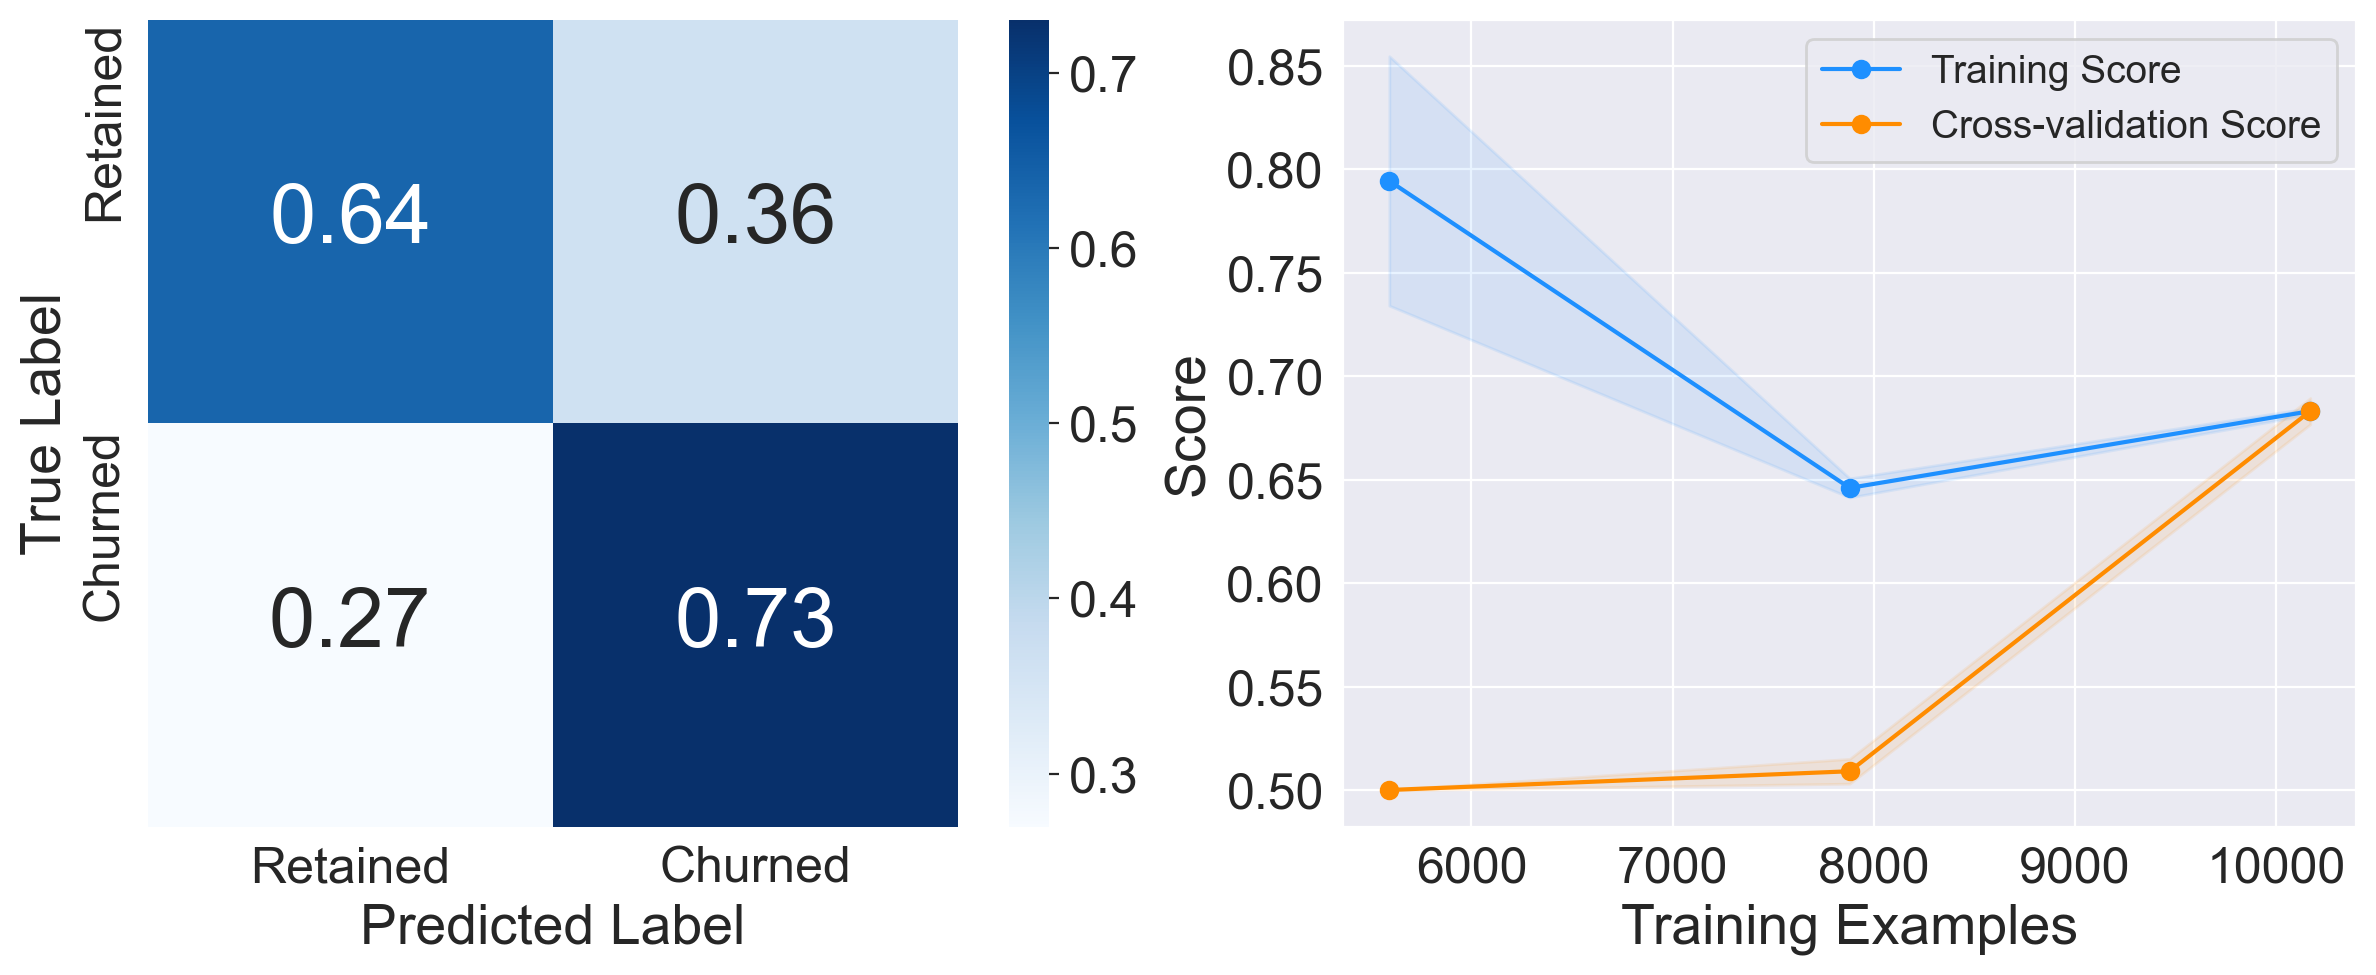

In [52]:
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

### Random Forest

##### Decision Tree
![Decision Tree](data/src/decision-tree.webp)

##### Random Forest
![Decision Tree](data/src/random-forest.webp)


c:\Users\demic\anaconda3\envs\customer-churn\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.76479126 0.76479126
 0.76306009 0.76306009        nan        nan        nan        nan
 0.76951108 0.76951108 0.77045584 0.77045584]
  warnings.warn(



 Random Forest
-------------------------------
   Best Score (recall): 0.77
   Best Parameters: 
      bootstrap: True
      criterion: gini
      max_depth: 6
      max_features: sqrt
      min_samples_leaf: 5
      min_samples_split: 2
      n_estimators: 100


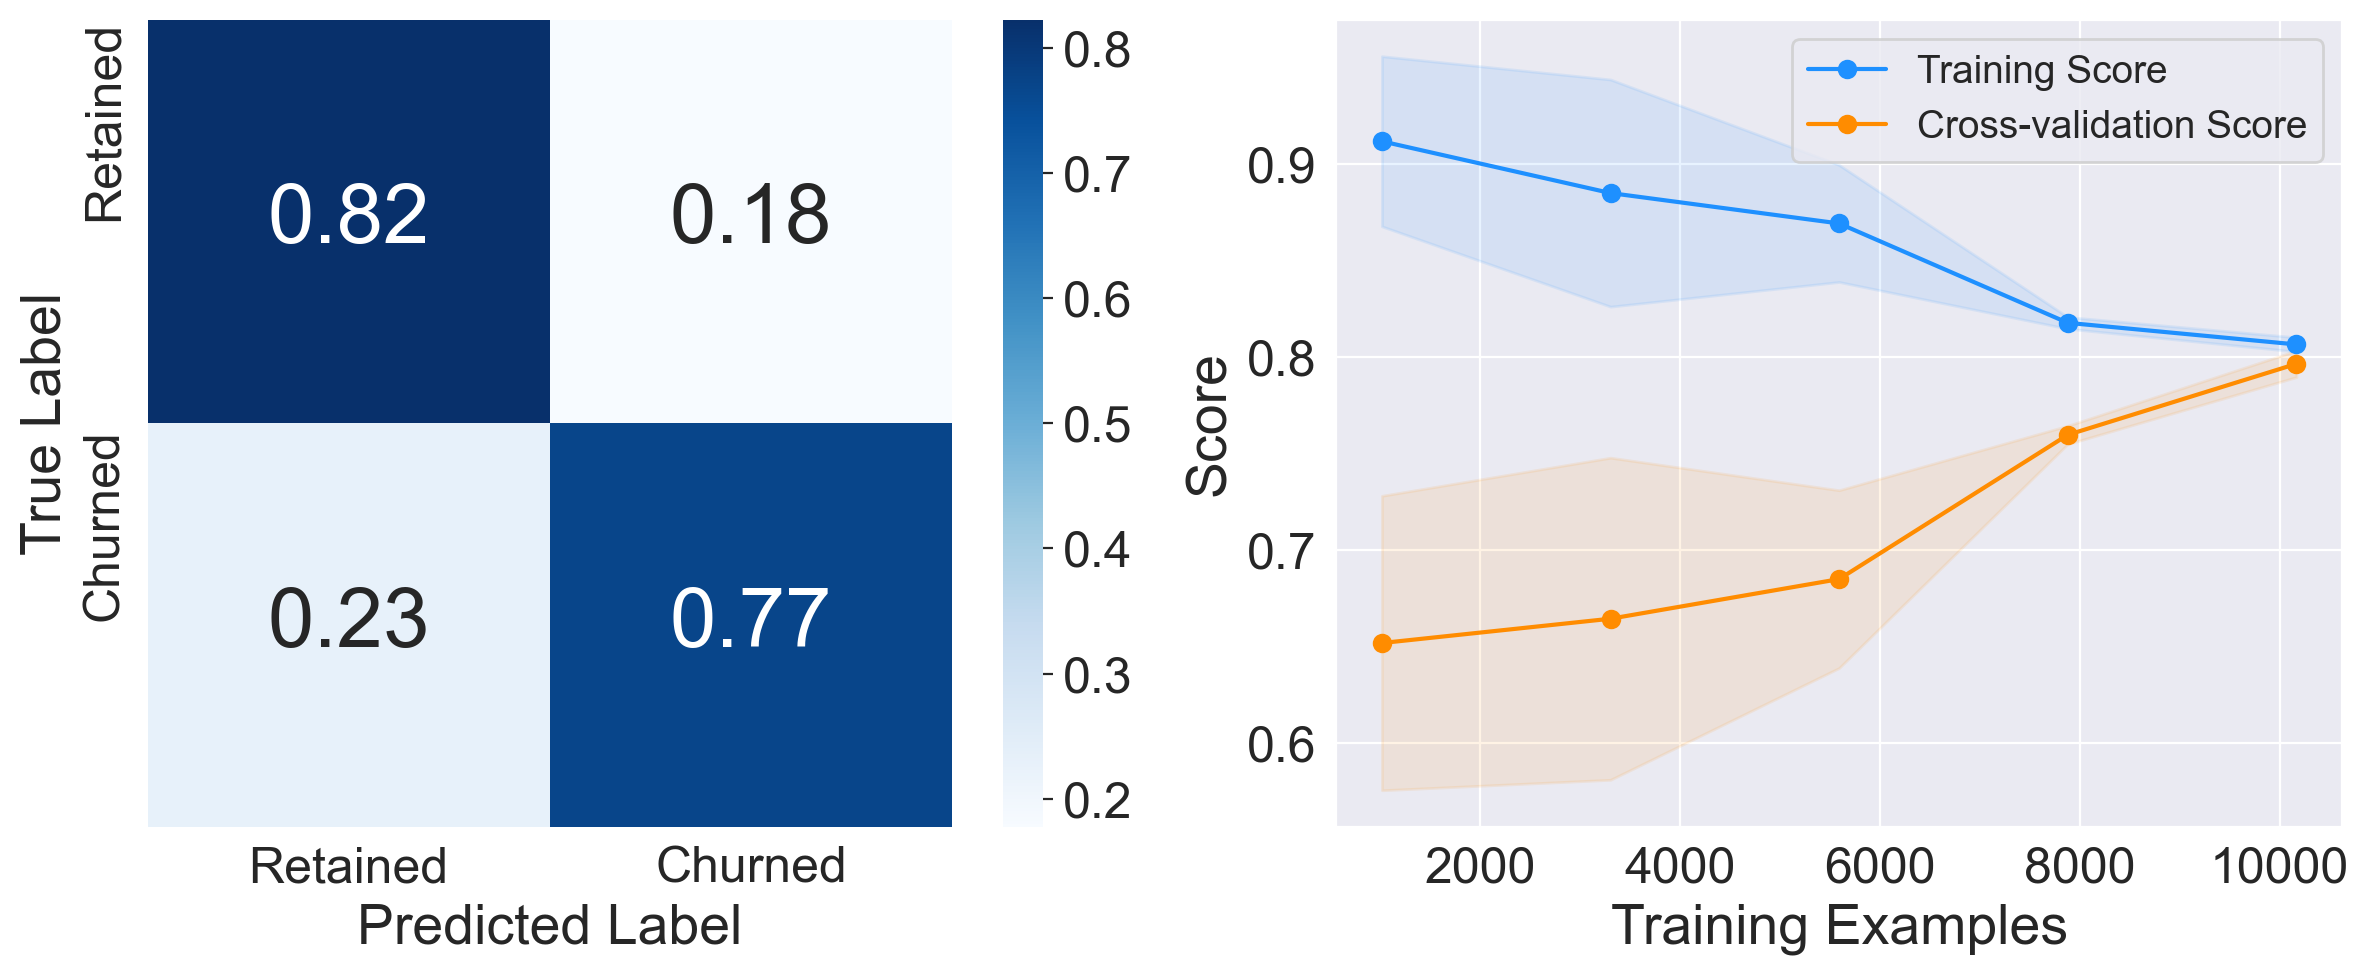

In [53]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [2, 3]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

<br>

# Results

## Feature Importance

Some classifiers allow us to visualise feature importance:

'Age' and 'NumOfProducts' seem like the most useful features for all classifiers, followed by 'IsActiveMember' and 'Balance'. On the other hand, 'CreditScore' is the least important feature with a small value close to zero for all estimators apart from LGBM. 

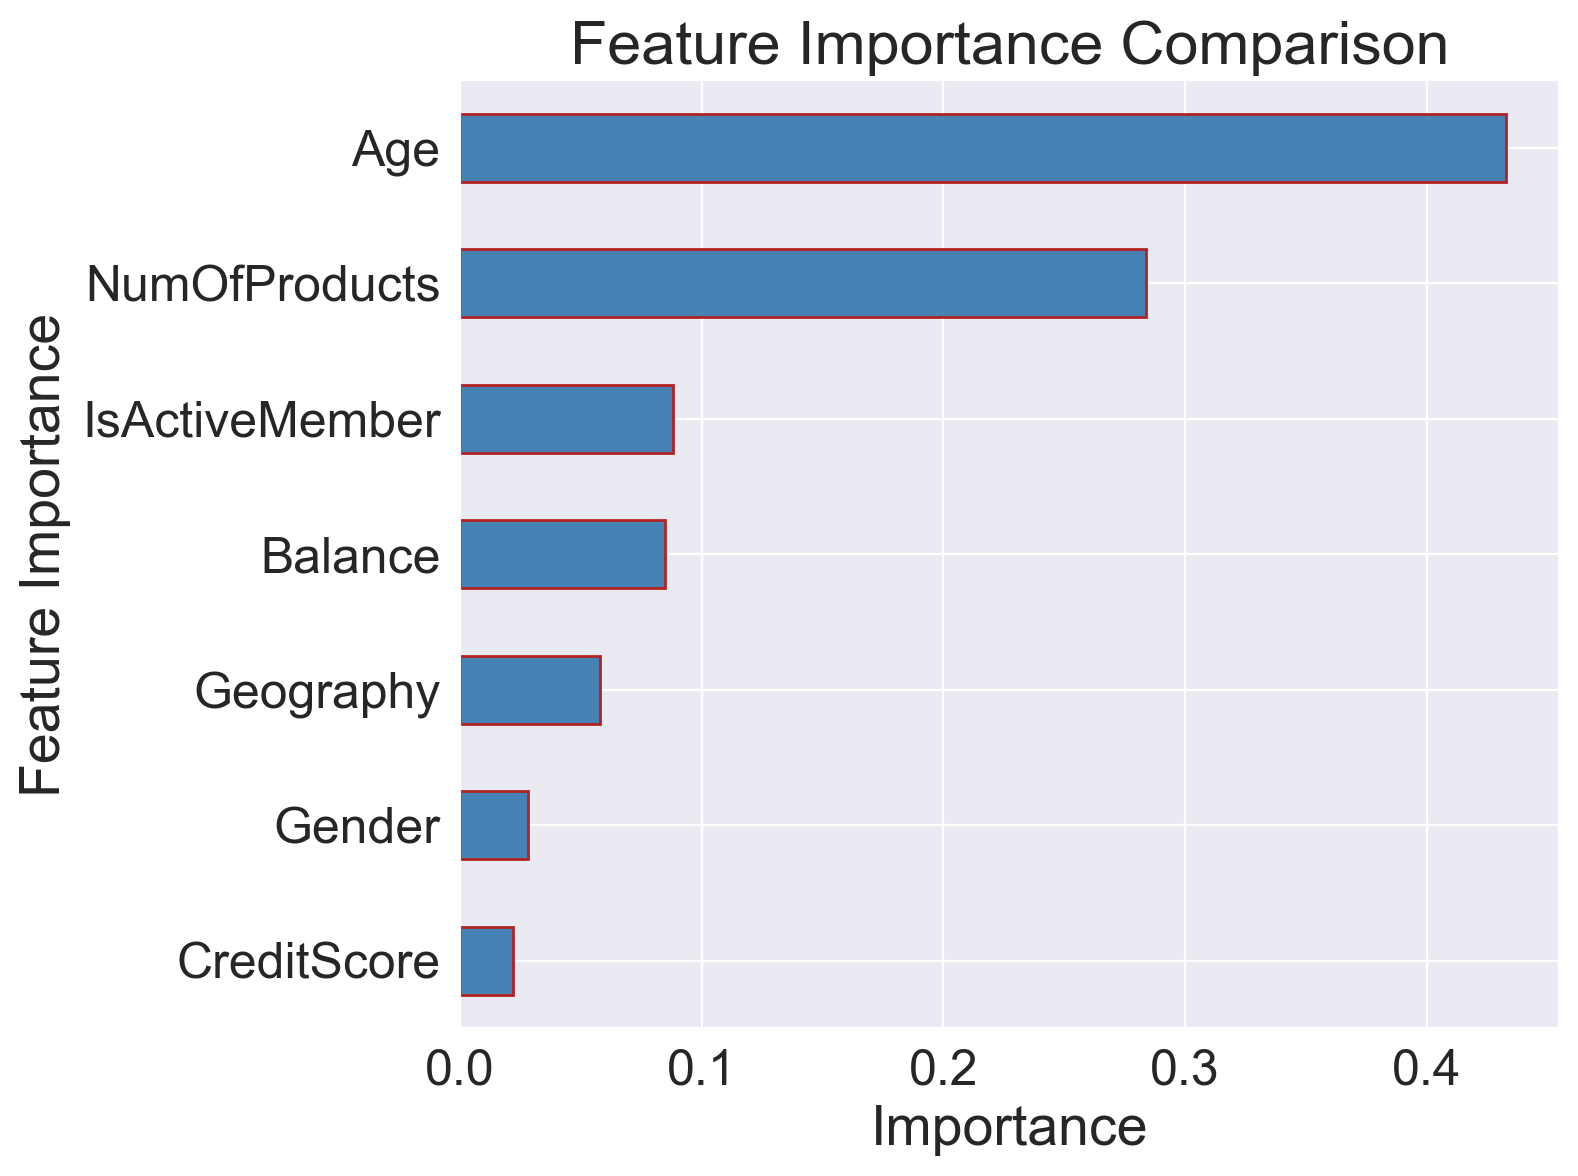

In [54]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (name, clf) in enumerate(zip(['RF'], [best_rf_clf])):
    plot_feature_imp(clf, name, colors_fi[i], ax)

plt.ylabel('Feature Importance')
plt.title('Feature Importance Comparison')
plt.tight_layout()
plt.show()

## Performance Comparison

Initially, we can compare the performance of our classifiers in terms of four individual metrics (Accuracy, precision, recall, and area under the ROC curve or simply AUC):

In [55]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='green', axis=0)

,Accuracy,Precision,Recall,AUC
LR,0.683134,0.667338,0.730334,0.733846
RF,0.796492,0.812780,0.770453,0.882553


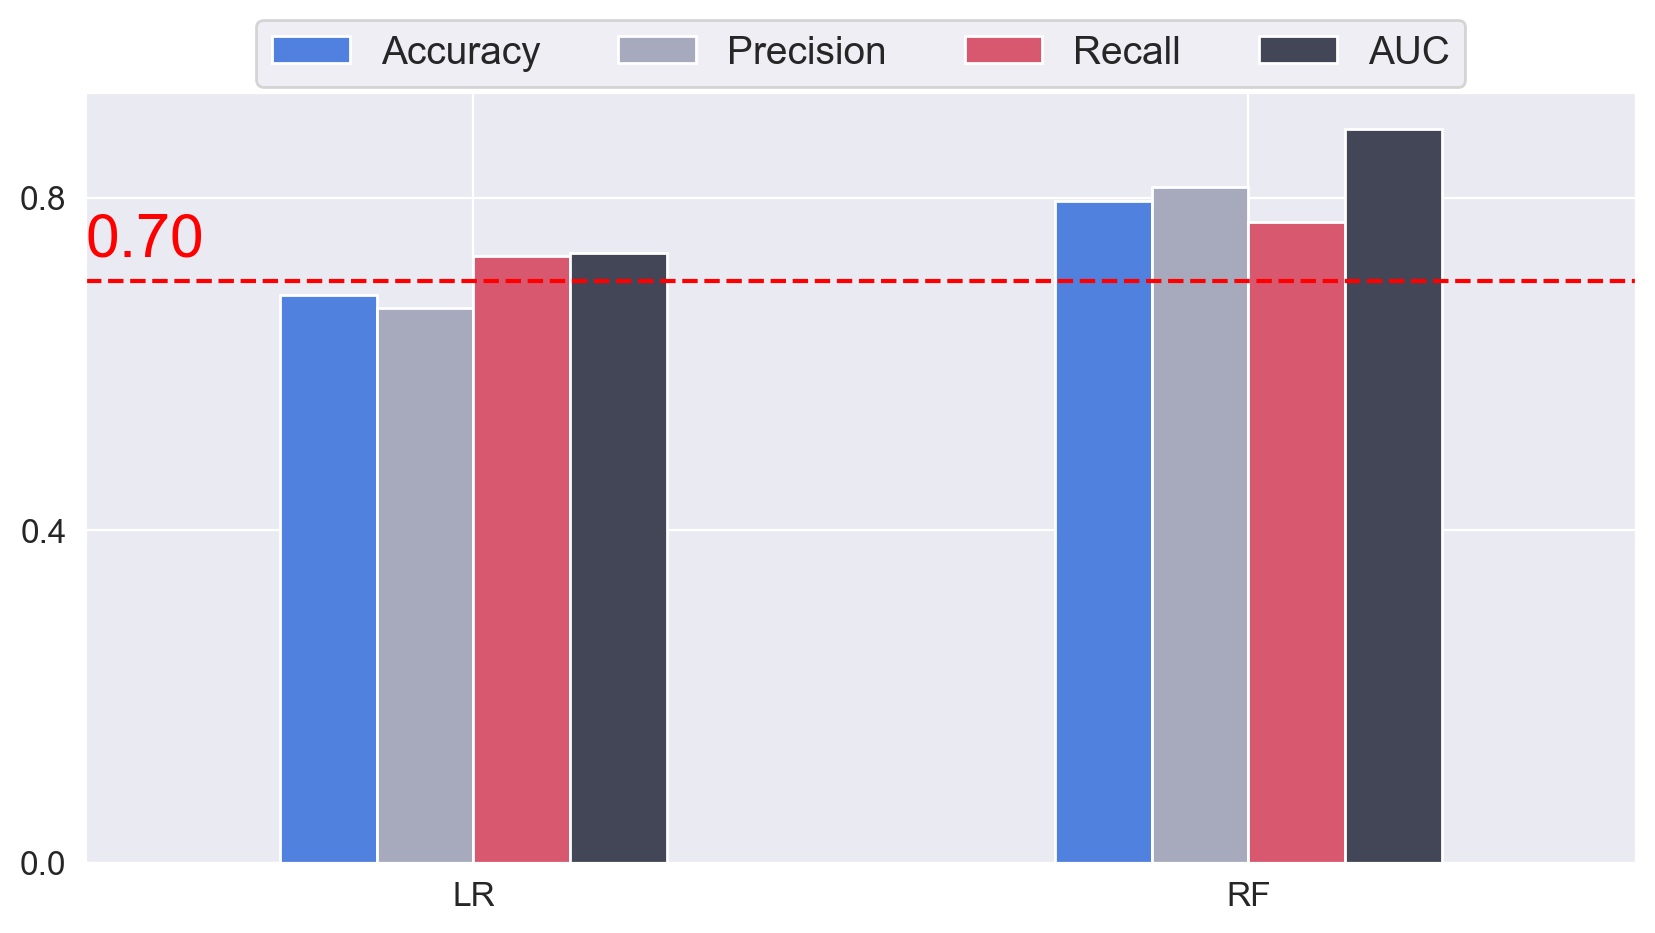

In [56]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center',
           fontsize=font_size - 6,
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='red');

<br>

# Evaluating the Test Set

Now is the time to evaluate the models on unseen data. First, we need to perform the same preprocessing steps as the training set.

In [57]:
test_df = test_df.drop(features_drop, axis=1)

test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])
test_df['Geography'] = test_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

test_df[scl_columns] = scaler.transform(test_df[scl_columns])  # not fit_transform, scaler has already been trained

y_test = test_df['Exited']
X_test = test_df.drop('Exited', axis=1)

print('✔️ Preprocessing Complete!')

✔️ Preprocessing Complete!


<br>

We will use the same method for comparing our classifiers as we did in the training set.

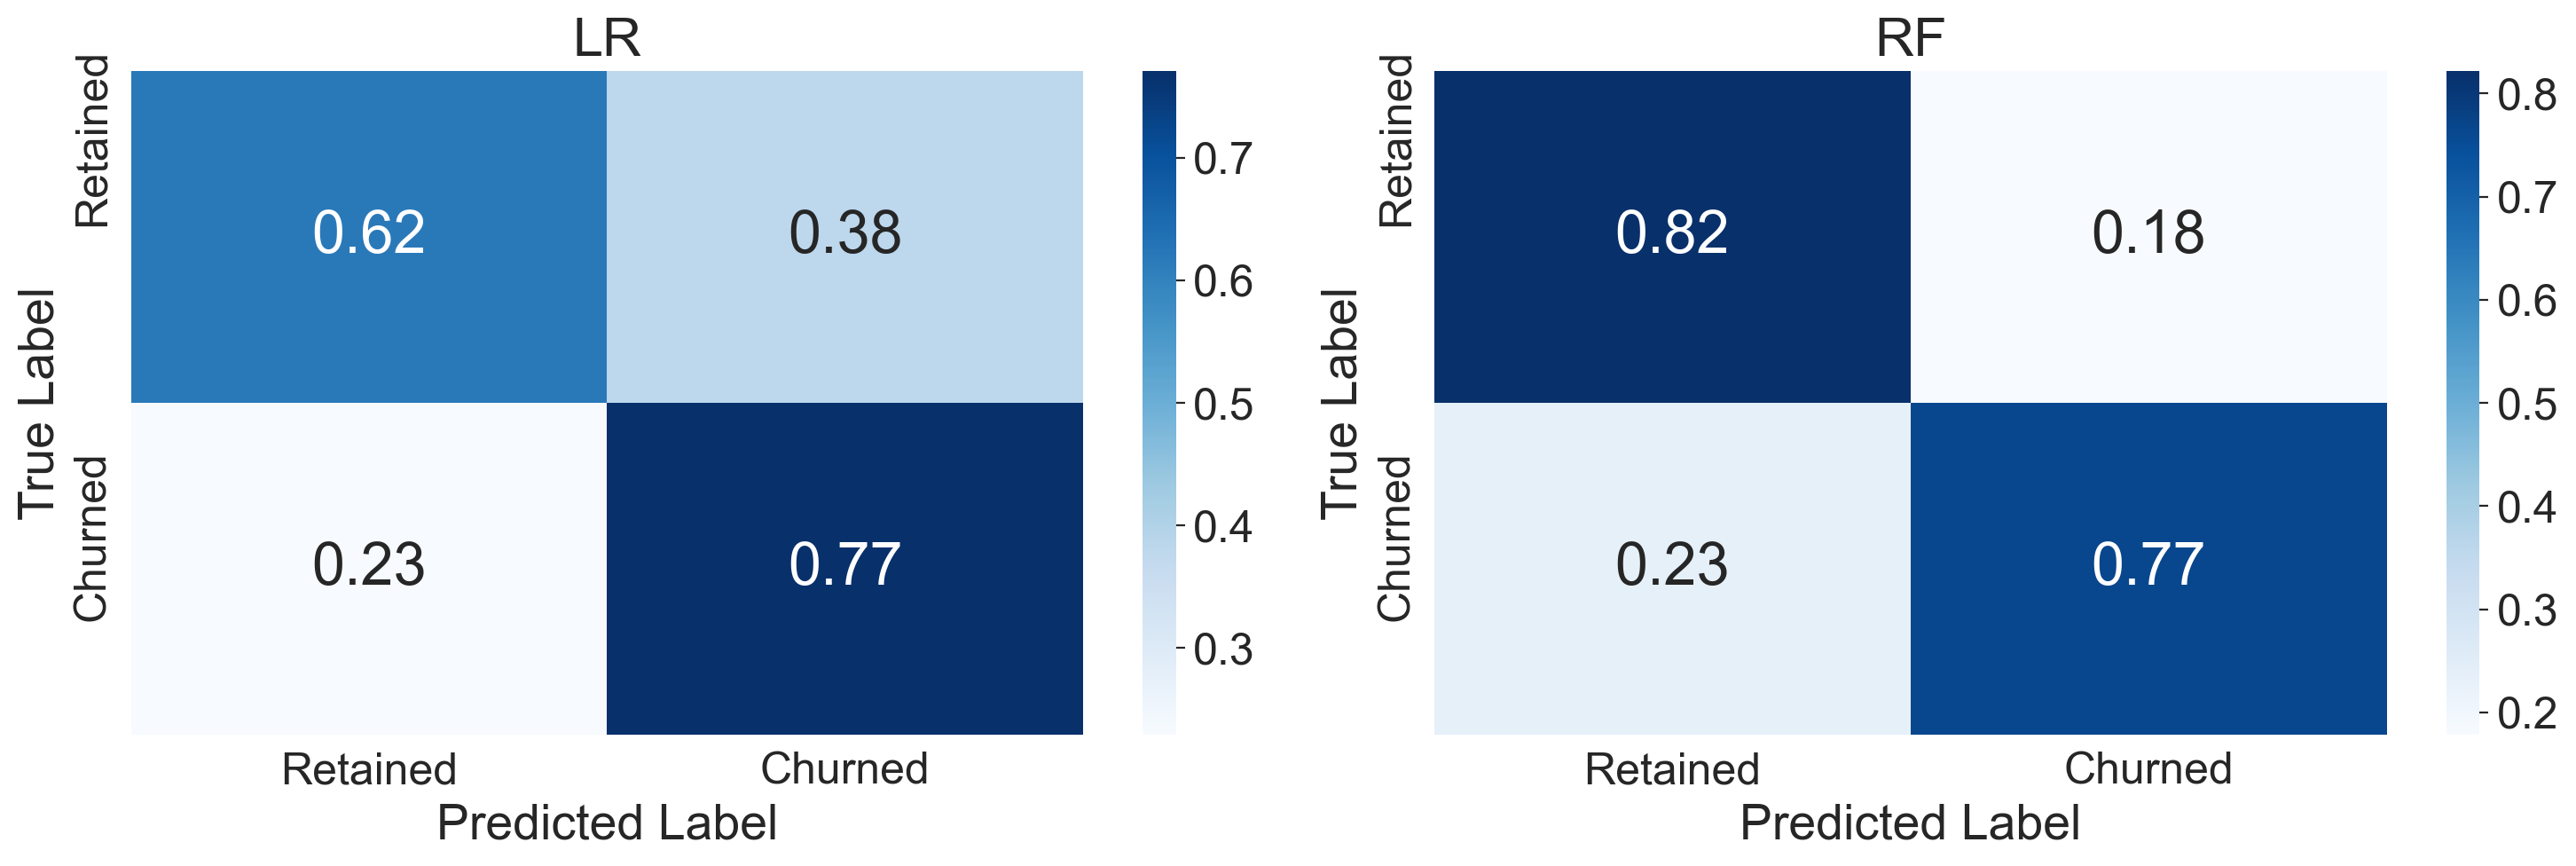

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, (name, clf) in enumerate(zip(['LR', 'RF'], 
                                    [best_lr_clf.best_estimator_, best_rf_clf.best_estimator_])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout();

In [59]:
comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='green', axis=0)

,Accuracy,Precision,Recall
LR,0.650000,0.331873,0.770992
RF,0.811000,0.512777,0.765903


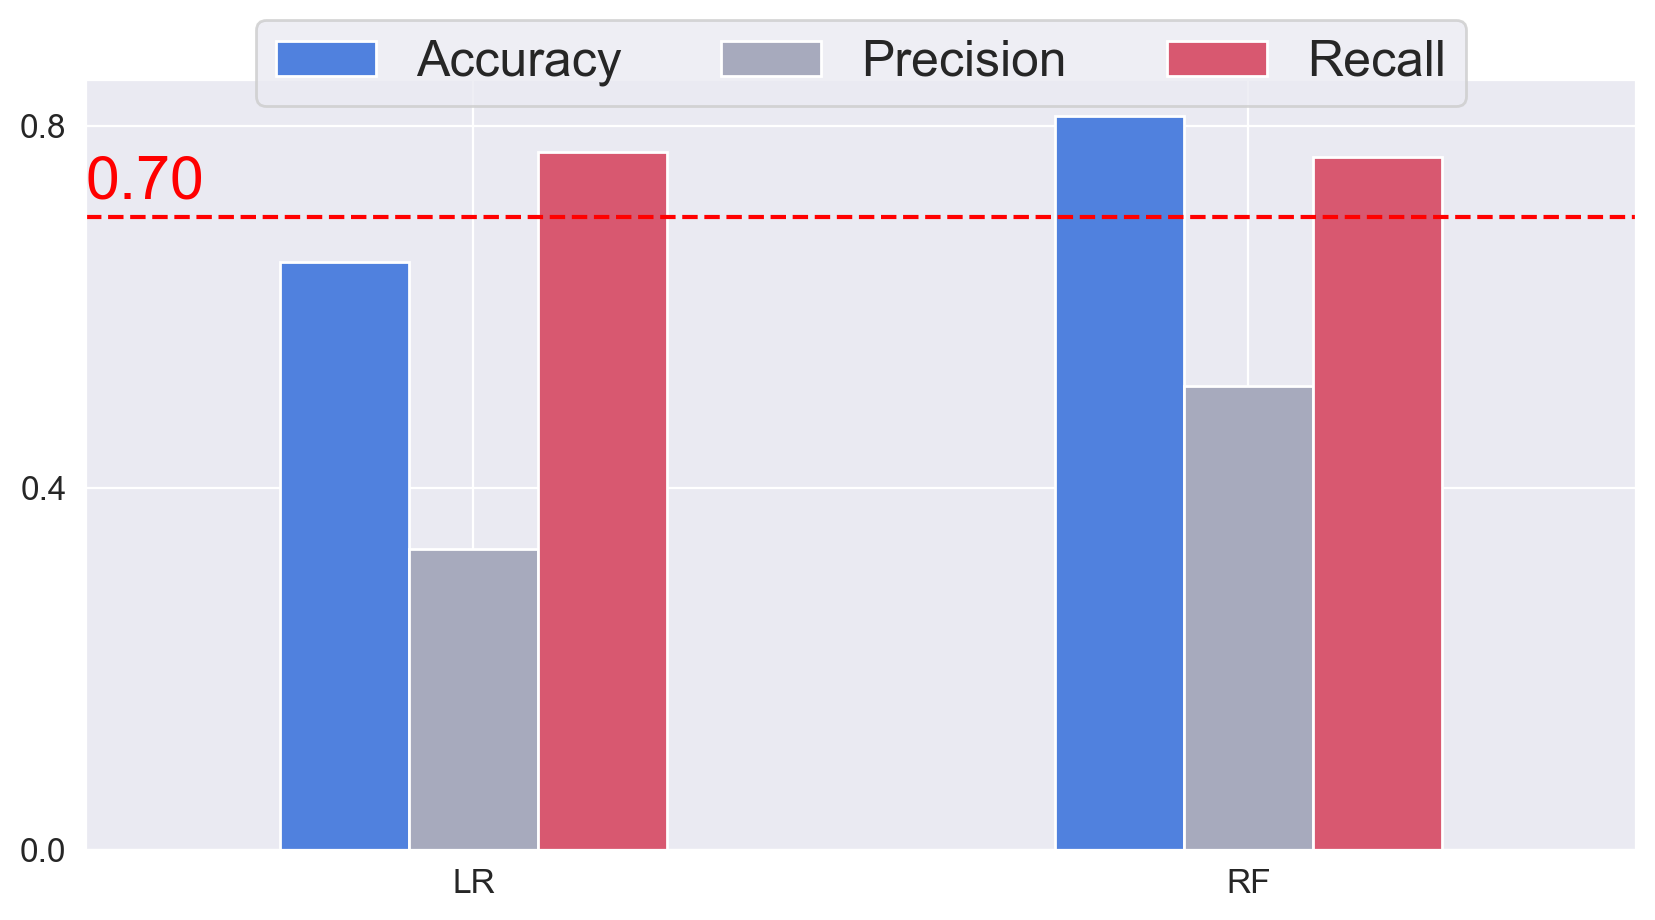

In [60]:
comparison_test_df.plot(kind='bar',
                        figsize=(10, 5),
                        fontsize=12,
                        color=['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc='upper center',
           ncol=len(comparison_test_df.columns),
           bbox_to_anchor=(0.5, 1.11))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.72, s='0.70', size=font_size + 2, color='red');

<br>

# Conclusions

Our final report to the bank should be based on two main points:

- **EDA** can help us identify which features contribute to customer churn. Additionally, **feature importance** analysis can quantify the importance of each feature in predicting the likelihood of churn. Our results reveal that the most significant feature is **age** (older customers are more likely to churn), followed by the **number of products** (having more products increases a customer’s likelihood to churn). The bank could use our findings to adapt and improve its services in a way that increases satisfaction for those customers more likely to churn.

- We can build several **machine learning models** with **recall** approximately equal to **78%**, meaning that they can successfully detect almost 80% of those customers more luckily to churn. Perhaps, adding more features or/and records could help us improve predictive performance. Therefore, the bank could benefit from investing in gathering more data.

<br>